## Gradients

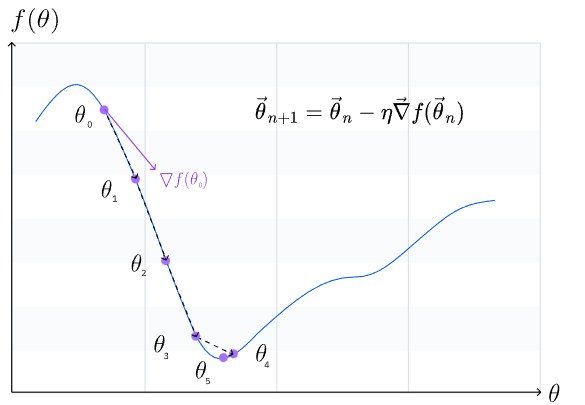

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

First, we define our parametrized state $\ket{\Psi (\vec{\theta})} = U(\vec{\theta}) \ket{00...0}$. Where $U(\vec{\theta})$ is the Qiskit [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit on two qubits

In [31]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import Z, I, StateFn, PauliExpectation, CircuitSampler, Gradient, NaturalGradient
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

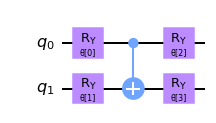

In [2]:
ansatz = RealAmplitudes(num_qubits = 2, reps = 1, entanglement = 'linear').decompose()
ansatz.draw(output='mpl')

Now we define the hamiltonian $\hat{H} = \hat{Z} \otimes \hat{Z}$

In [3]:
hamiltonian = Z ^ Z

Now we compute the expecation value

In [4]:
expectation = StateFn(hamiltonian, is_measurement = True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next, we write a function to simulate the measurement of the expectation value

In [5]:
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                  # set a seed for reproducibility
                                  shots = 8192, seed_simulator = 2718,
                                  seed_transpiler = 2718)

sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params = value_dict).eval()
    return np.real(result)

Now, what's the derivative of the expectation value with respect to parameter $\theta_{i}$ at point $\vec{p}$?

$$ \frac{\partial}{\partial \theta_{i}} = \bra{\Psi(\vec{\theta})} \hat{H} \ket{\Psi (\vec{\theta})} \Big|_{\vec{\theta} = \vec{p}} $$

With a random point $\vec{p}$ and an index $i = 2$ we have

In [6]:
point = np.random.random(ansatz.num_parameters)
INDEX = 2

## Finite difference gradients

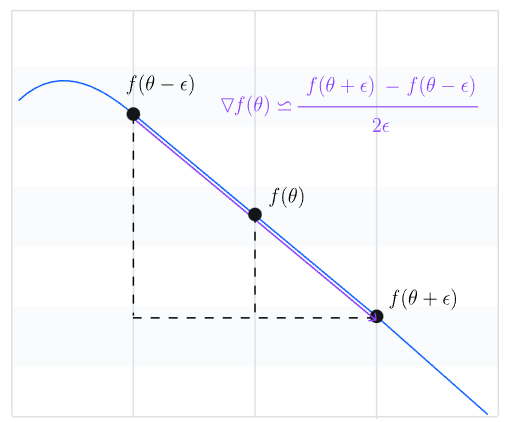

If we are interested in finding the gradient of $f(\vec{\theta})$, we can choose some small distance $\epsilon$ and calculate $f(\vec{\theta} + \epsilon)$ and $f(\vec{\theta} - \epsilon)$ and take the difference, divided by the distance we obtain

$$ \vec{\nabla} f(\vec{\theta}) \approx \frac{1}{2\epsilon} \left( f(\vec{\theta} + \epsilon) - f(\vec{\theta} - \epsilon) \right) $$

In [7]:
EPS = 0.2
# make identity vector with a 1 at index, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus  = point + EPS*e_i
minus = point - EPS*e_i

finite_difference = ( (evaluate_expectation(plus) - evaluate_expectation(minus))/(2*EPS) )
print(finite_difference)

0.13732910156250028


Or we can use the Qiskit's [Gradient class](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.Gradient.html)

In [8]:
shifter = Gradient('fin_diff', analytic = False, epsilon = EPS)
grad    = shifter.convert(expectation, params = ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.1727294921875

This method it's a little noisy

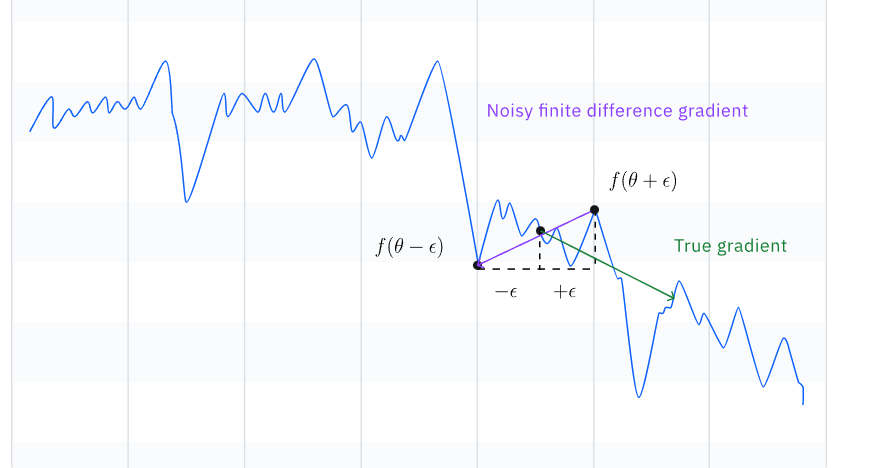

## Analytic gradients

This method evaluate the analytic formula for the gradients. It's difficult because we have to do manual calculations. For a simple circuit consisting of only Pauli rotations, without any coefficients, then the *the parameter shift rule* is simplified and says that the analytic gradient is

$$ \frac{\partial f}{\partial \theta_{i}} = \frac{ f \left( \vec{\theta} + \frac{\pi}{2}\vec{e}_{i} \right) - f \left( \vec{\theta} - \frac{\pi}{2}\vec{e}_{i} \right) }{2} $$

Let's try calculate it by hand

In [9]:
EPS = np.pi/2
e_i = np.identity(point.size)[:,INDEX]

plus  = point + EPS*e_i
minus = point - EPS*e_i

finite_difference = ( evaluate_expectation(plus) - evaluate_expectation(minus) )/2
print(finite_difference)

0.144287109375


And using Qiskit Gradient class

In [10]:
shifter = Gradient() # parameter shift rule is the default
grad    = shifter.convert(expectation, params = ansatz.parameters[INDEX])
sampler.convert(grad, value_dict).eval().real

0.15173339843749994

Now it's very similar. Let's try to optimize the expectation value.

First, we fixed an initial point for reproducibility

In [11]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Now we need a function to evaluate the gradient

In [12]:
gradient = Gradient().convert(expectation)
gradient_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_pauli_basis, params = value_dict).eval()
    return np.real(result)

To compare the convergence of the optimiezers, we can keep track of the loss of each step with the callback function
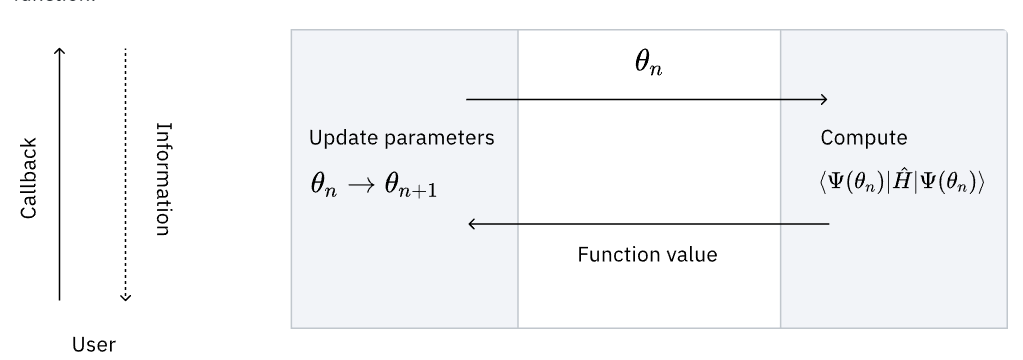

In [14]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values but we only store the third"""
        self.loss.append(ftheta)
        
gd_log = OptimizerLog()
gd     = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = gd_log.update)

Now we optimize and plot the loss

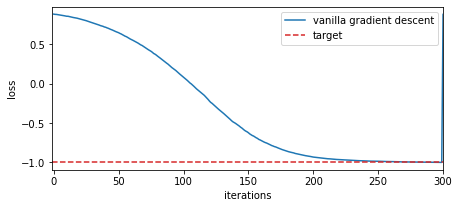

In [28]:
result = gd.minimize(fun = evaluate_expectation, # function to minimize
                     x0 = initial_point,         # initial point
                     jac = evaluate_gradient     # function to evaluate the gradient
                    )

plt.figure(figsize=(7,3))

plt.plot(gd_log.loss, label = 'vanilla gradient descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim([-1,300])
plt.legend()

## Natural gradients

Gradient descent is good, but it has problems. If the topology of the problem change, we have to change the loss and leraning rate. For example, in the figure the x-axis change, and with the same initial point and learning rate we cannot find the minimum.
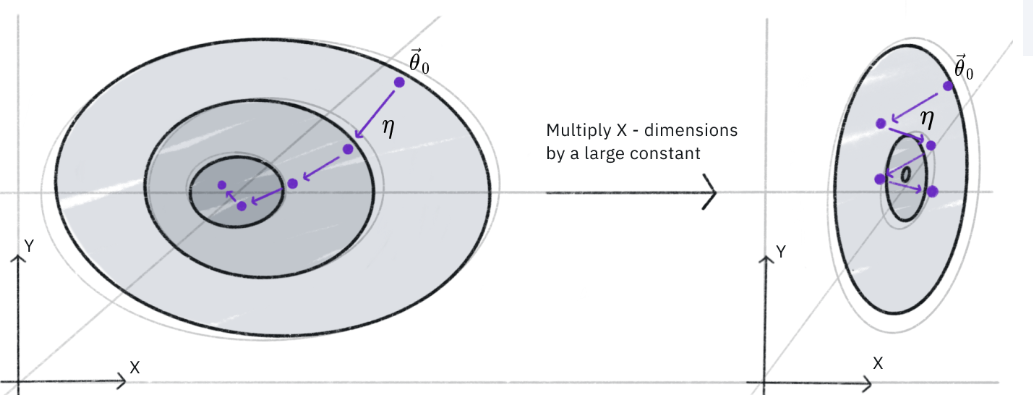

The idea of natural gradients is change the way we determine the loss landscape $\theta_{n+1}$ from $\theta_{n}$. In vanilla gradients, we use the euclidean distance, but we are gonna use a distance that depends on our model $d = \Big| \braket{\Psi (\vec{\theta}_{n})}{\Psi (\vec{\theta}_{n+1})} \Big|^{2}$
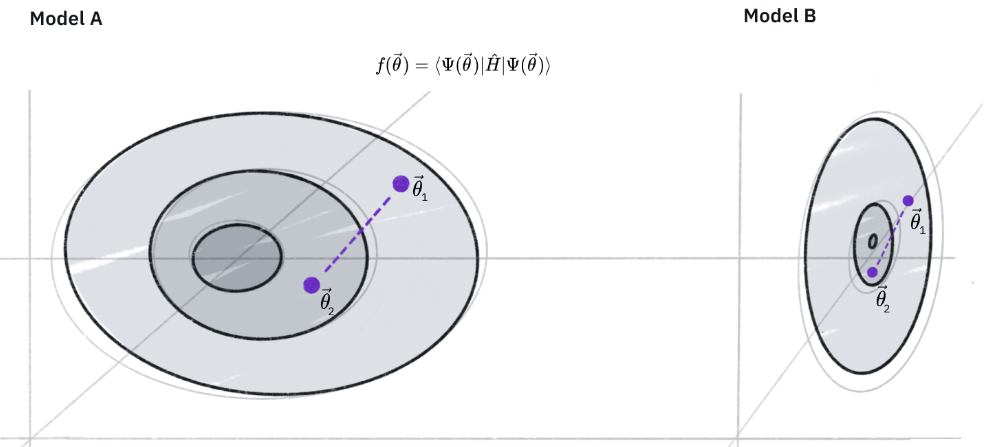
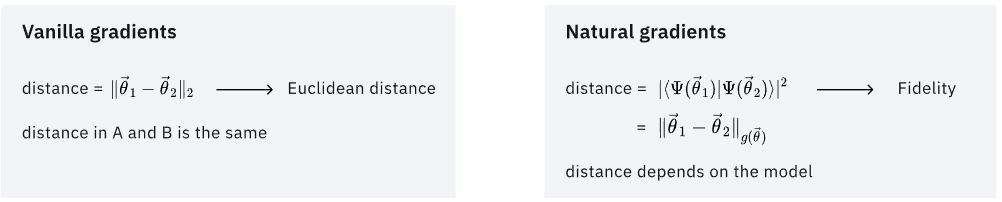

The *Quantum Natural Gradient* is define by

$$ \vec{\theta}_{n+1} = \vec{\theta}_{n} - \eta g^{-1} \left( \vec{\theta} \right) \vec{\nabla}f \left( \vec{\theta}_{n} \right) $$

where $g_{ij}$ is the *Quantum Fisher Information*,

$$ g_{ij} \left( \vec{\theta} \right) = Re \left[ \braket{ \frac{\partial \Psi}{\partial \theta_{i}} }{ \frac{\partial \Psi}{\partial \theta_{j}} } - \braket{ \frac{\partial \Psi}{\partial \theta_{i}} }{ \Psi } \braket{ \Psi }{ \frac{\partial \Psi}{\partial \theta_{j}} } \right], $$

and allows us to transform the steepest descent in the euclidean parameter space tp the steepest descent in the model space. This is called *Quantum Natural Gradient*.
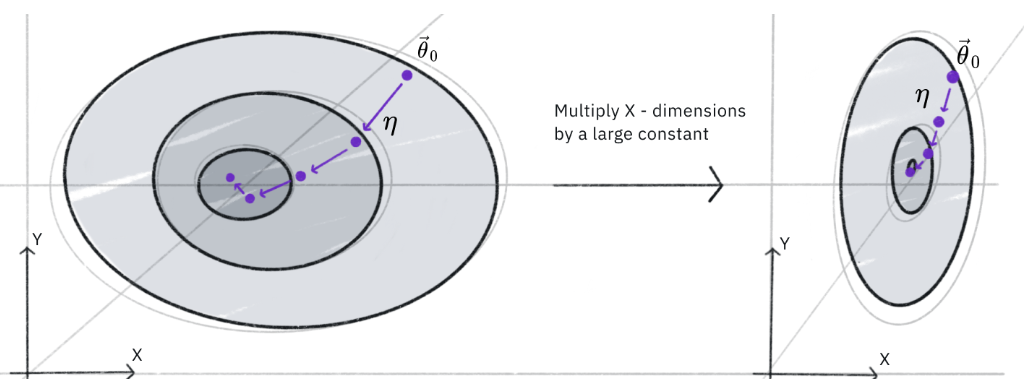

Wen can write a function that evaluates the natural gradients

In [21]:
natural_gradient = NaturalGradient(regularization = 'ridge').convert(expectation)

natural_gradient_oauli_basis = PauliExpectation().convert(natural_gradient)

sampler = CircuitSampler(quantum_instance, caching = 'all')

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient, params = value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587277 -0.86457077 -0.9808614  -0.33820196]


They differ, as it's expected. Let's see how this influence on the convergence

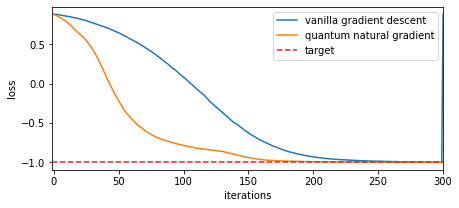

In [29]:
qng_log = OptimizerLog()
qng     = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = qng_log.update)

result  = qng.minimize(evaluate_expectation, initial_point, evaluate_natural_gradient)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim([-1,300])
plt.legend();

We see that QNG approaches faster to the target, but needs to evaluate many more quantum circuits.

## Simultaneous Perturbation Stochastic Approximation

Looking at $f \left( \vec{\theta} \right)$ as a vector, if we want to perform $\vec{\nabla} f \left( \vec{\theta} \right)$, we need to calculate the partial derivation of $f \left( \vec{\theta} \right)$ with respect to each parameter, meaning we would need $2 N$ functions evaluations for $N$ parameters to calculate the gradient.
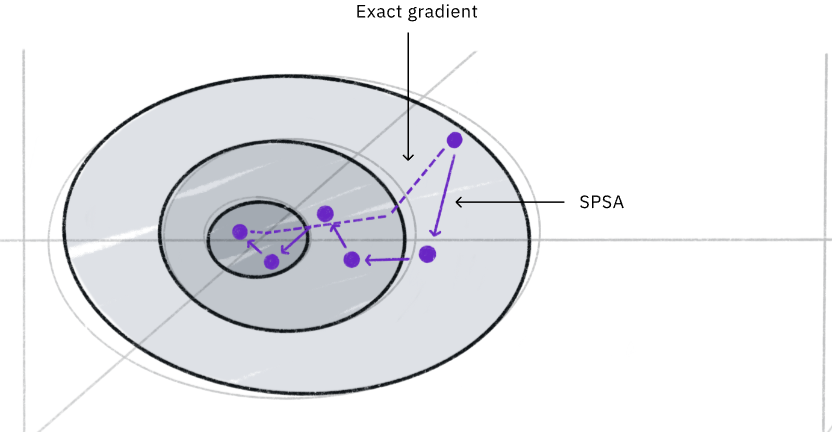

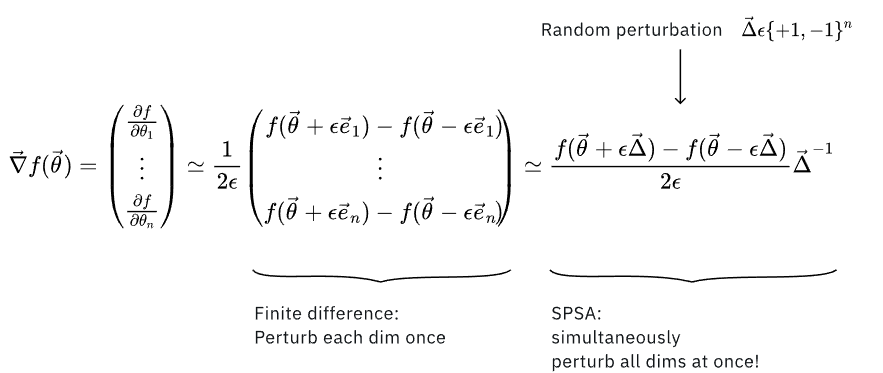

Simultaneous Perturbation (A perturbation is a small change we make to an idealized system) Stochastic (A non-deterministic approach, i.e. depending on randomness) Approximation (SPSA) is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don´t care about the exact values but only about convergencem an unbiased sampling should on average work equally well.

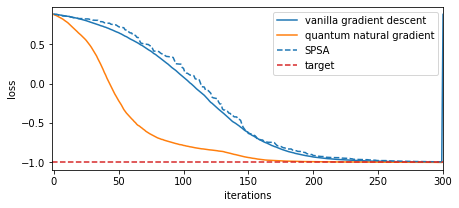

In [30]:
spsa_log = OptimizerLog()
spsa     = SPSA(maxiter = 300, learning_rate = 0.01, perturbation = 0.01,
                callback = spsa_log.update)
result   = spsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim([-1,300])
plt.legend();

We see that SPSA follows the GD curve but with less cost.So, we can do the same for the QNG. The idea is not only sample from the gradient, but from the quantum Fisher information too and thus the natural gradient

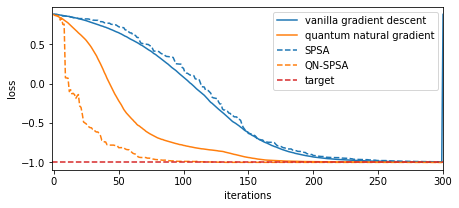

In [35]:
qnspsa_log = OptimizerLog()
fidelity   = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation = PauliExpectation())
qnspsa     = QNSPSA(fidelity, maxiter = 300, learning_rate = 0.01, perturbation = 0.01,
                   callback = qnspsa_log.update)
result     = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim([-1,300])
plt.legend();

The vanilla and natural gradient cost are linear and quadratic, respectively,  while the costs for SPSA and QNSPSA are constant, i.e. independent of the number of parameters. There is the small offset between the costs for SPSA and QNSPSA as more evaluations are required to approximate the natural gradient

### <span style="color:green"> Training in practice </span>
In this era of near-term quantum computing, circuit evaluations are expensive, and readouts are not perfect due to the noisy nature of the devices. Therefore in practice, people often resort to using SPSA. To improve convergence, we don't use a constant learning rate, but an exponentially decreasing one. The diagram below shows the typical convergence between a constant learning rate (dotted lines) versus an exponentially decreasing one (solid lines). We see that the convergence for a constant learning rate is smooth decreasing line, while the convergence for an exponentially decreasing one is steeper and more staggered. This works well if you know what your loss function looks like.
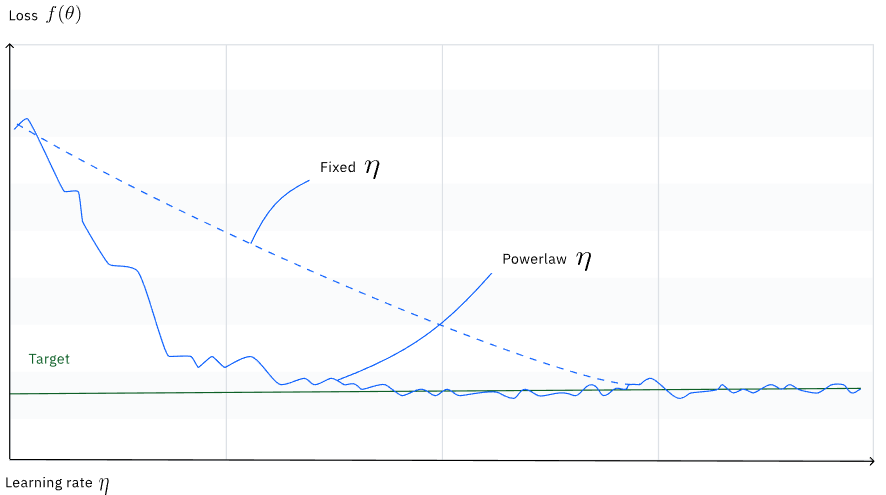


Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

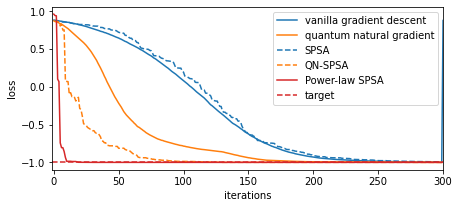

In [37]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim([-1,300])
plt.legend();

We see here that it works the best of all the methods for this small model. For larger models, the convergence will probably be more like the natural gradient.